<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Model Read

In [2]:
#===============================================
# Basic Imports
BASE_FOLDER = '../../'
%run -i ..\..\utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i ..\..\utility\modeling\JupyterLoad_modeling.py

from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import glob
import seaborn as sns
sns.set_style("whitegrid")

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe


In [9]:
def read_pipes(name='models_aggregated.pkl'):
    list_of_unsup_pipes = glob.glob(BASE_FOLDER + '/modeling/unsupervised/pipes/*.pkl', recursive=True)
    list_of_pseudosup_pipes = glob.glob(BASE_FOLDER + '/modeling/pseudo_supervised/pipes/*.pkl', recursive=True)
    columns = ['model_path'
        , 'roc_auc_framed'
        , 'roc_auc_aggr'
        , 'SNR'
        , 'machine'
        , 'ID'
        , 'feature_type'
        , 'feature_params'
        , 'model_type'
        , 'model_params']
    df = pd.DataFrame(columns=columns)

    for i, pipe_path in enumerate(tqdm(list_of_unsup_pipes + list_of_pseudosup_pipes)):
        with open(pipe_path, 'rb') as pipe_file:
            pipe = pickle.load(pipe_file)

            predictions = pipe.df_test.groupby(by='path').sum().pred_scores
            pipe.df_test['ground_truth'] = pipe.ground_truth
            labels = pipe.df_test.groupby(by='path').median().ground_truth
            roc_auc_aggr = roc_auc_score(labels, predictions)

            data=[[
                pipe_path,
                pipe.roc_auc,
                roc_auc_aggr,
                pipe.task['SNR'],
                pipe.task['machine'],
                pipe.task['ID'],
                pipe.task['feat_col'],
                pipe.task['feat'],
                pipe.model.name,
                pipe.model_args]]
            df = df.append(pd.DataFrame(data=data, columns=columns))
    
    
    # dataframe postprocessing
    df = df.reset_index()
    df['roc_diff'] = df.roc_auc_aggr - df.roc_auc_framed

    df_tmp = pd.DataFrame([])
    for i, row in df.iterrows():
        for key, value in row.feature_params.items():
            row['feat_'+key] = value
        for key, value in row.model_params.items():
            row['model_'+key] = value
        df_tmp = df_tmp.append(row)

    df_tmp = df_tmp.join(pd.Series(['sporadic' if machine in ['slider', 'valve'] else 'continuous' for machine in df.machine], name='activation_type', index=df.index))

    df_tmp.drop_duplicates(subset=['ID', 'SNR', 'feat_function', 'feature_type', 'index',
    'machine', 'model_max_features', 'model_n_estimators', 'model_path', 
    'model_random_state', 'model_type', 'model_C', 'model_degree',
    'model_kernel', 'model_n_jobs', 'model_epochs', 'model_contamination',
    'feat_frames', 'model_n_components', 'activation_type'])

    return df_tmp


In [10]:
name = 'models_agg.dataframe'
if not os.path.exists(name):
    df = read_pipes(name)
    df.to_pickle(name)
else:
    df = pd.read_pickle(name)


  7%|█████▌                                                                         | 112/1596 [00:46<15:40,  1.58it/s]


 11%|████████▊                                                                      | 178/1596 [01:45<20:29,  1.15it/s]


 15%|████████████                                                                   | 244/1596 [02:44<20:20,  1.11it/s]


 20%|███████████████▉                                                               | 321/1596 [03:36<18:14,  1.16it/s]


 24%|███████████████████▏                                                           | 387/1596 [04:34<14:25,  1.40it/s]


 28%|██████████████████████▍                                                        | 453/1596 [05:33<12:18,  1.55it/s]


 34%|██████████████████████████▌                                                    | 537/1596 [06:21<16:06,  1.10it/s]


 38%|█████████████████████████████▊                                                 | 603/1596 [07:16<12:19,  1.34it/s]


 42%|█████████████████████████████████                                              | 669/1596 [08:12<11:27,  1.35it/s]


 46%|████████████████████████████████████▍                                          | 735/1596 [09:03<12:09,  1.18it/s]


 50%|███████████████████████████████████████▋                                       | 801/1596 [09:55<13:05,  1.01it/s]


 55%|███████████████████████████████████████████▊                                   | 885/1596 [10:42<11:32,  1.03it/s]


 60%|███████████████████████████████████████████████                                | 951/1596 [11:39<10:28,  1.03it/s]


 64%|█████████████████████████████████████████████████▋                            | 1017/1596 [12:35<08:08,  1.19it/s]


 68%|████████████████████████████████████████████████████▉                         | 1083/1596 [13:34<06:46,  1.26it/s]


 74%|█████████████████████████████████████████████████████████▍                    | 1175/1596 [14:01<01:43,  4.06it/s]


 79%|█████████████████████████████████████████████████████████████▉                | 1267/1596 [14:26<01:19,  4.13it/s]


 86%|██████████████████████████████████████████████████████████████████▉           | 1369/1596 [14:50<01:39,  2.27it/s]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1519/1596 [15:12<00:11,  6.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1596/1596 [15:19<00:00,  1.74it/s]


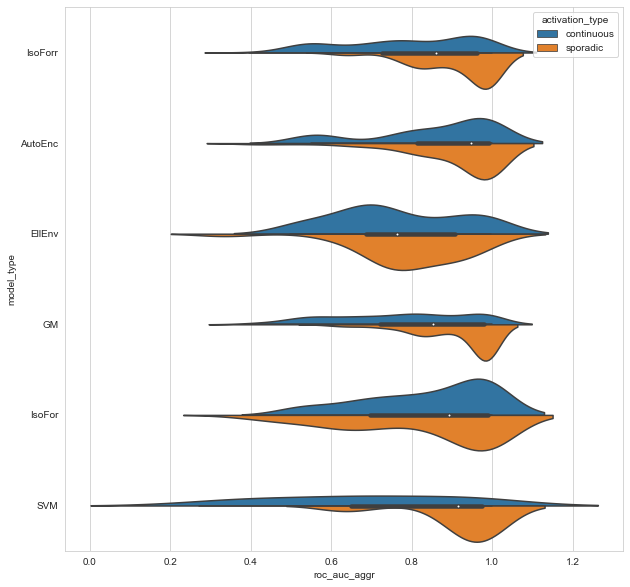

In [20]:
#df.boxplot(column='roc_auc_aggr', by=['model_type', 'activation_type'], figsize=(10,10), vert=False)
plt.figure(figsize=(10,10))
sns.violinplot(data=df, x='roc_auc_aggr', y='model_type', hue='activation_type', split=True)

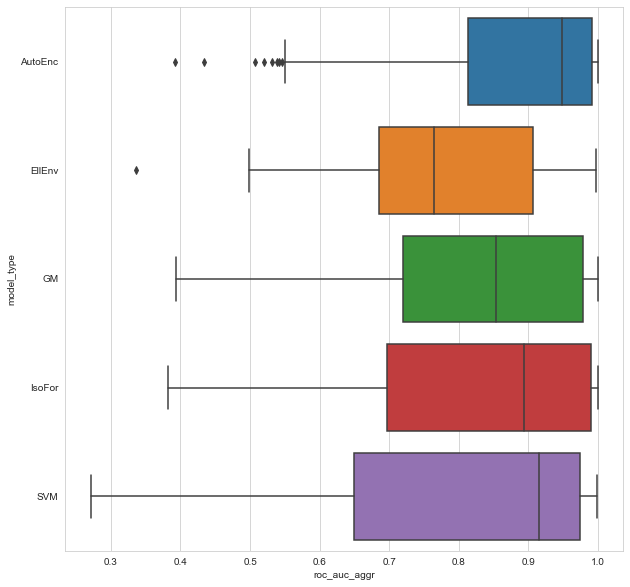

In [34]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df[df.model_type != 'IsoForr'], x='roc_auc_aggr', y='model_type')

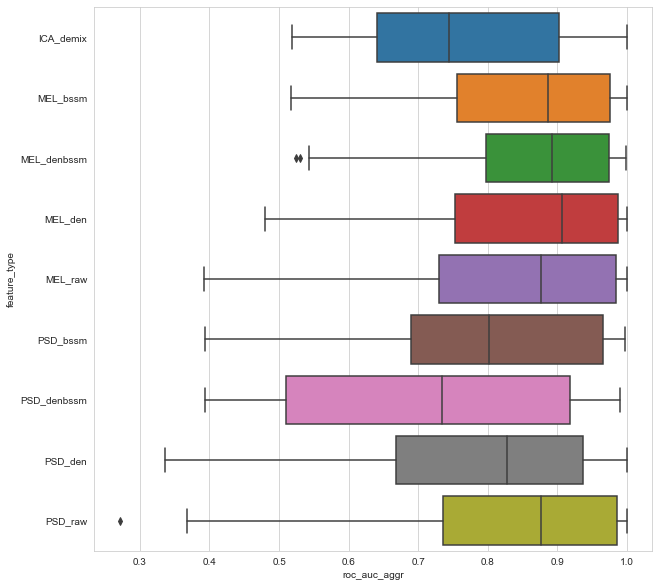

In [31]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='roc_auc_aggr', y='feature_type')

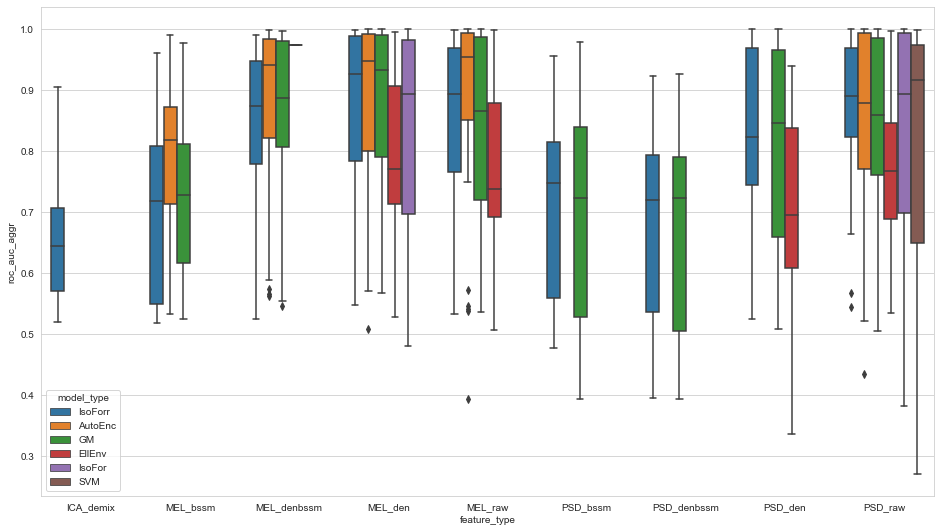

In [23]:
mask = ((df.feature_type == 'PSD_raw') | (df.feature_type == 'PSD_den') | (df.feature_type == 'MEL_raw') | (df.feature_type == 'MEL_denbssm') | (df.feature_type == 'MEL_den') | (df.SNR == 'min6dB'))
plt.figure(figsize=(16,9))
sns.boxplot(data=df[mask], y='roc_auc_aggr', x='feature_type', hue='model_type')

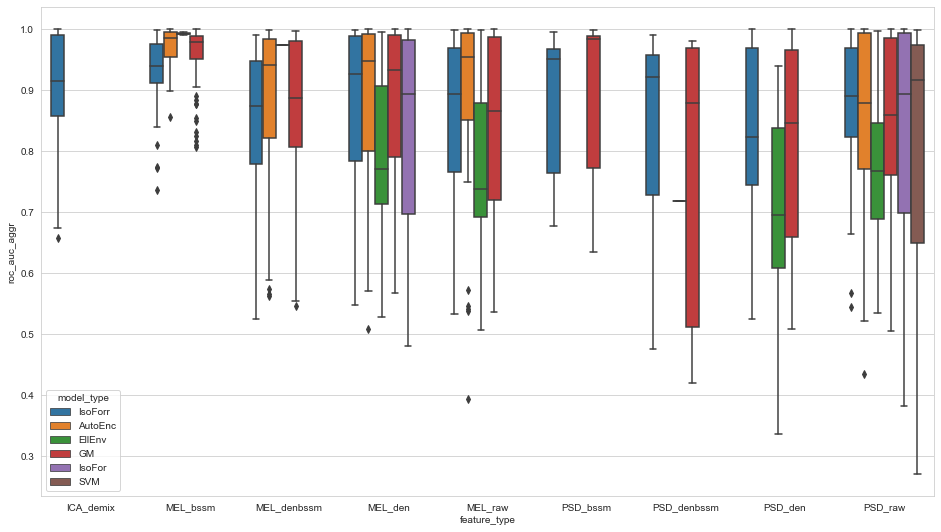

In [24]:
mask = ((df.feature_type == 'PSD_raw') | (df.feature_type == 'PSD_den') | (df.feature_type == 'MEL_raw') | (df.feature_type == 'MEL_denbssm') | (df.feature_type == 'MEL_den') | (df.SNR == '6dB'))
plt.figure(figsize=(16,9))
sns.boxplot(data=df[mask], y='roc_auc_aggr', x='feature_type', hue='model_type')

<Figure size 720x720 with 0 Axes>

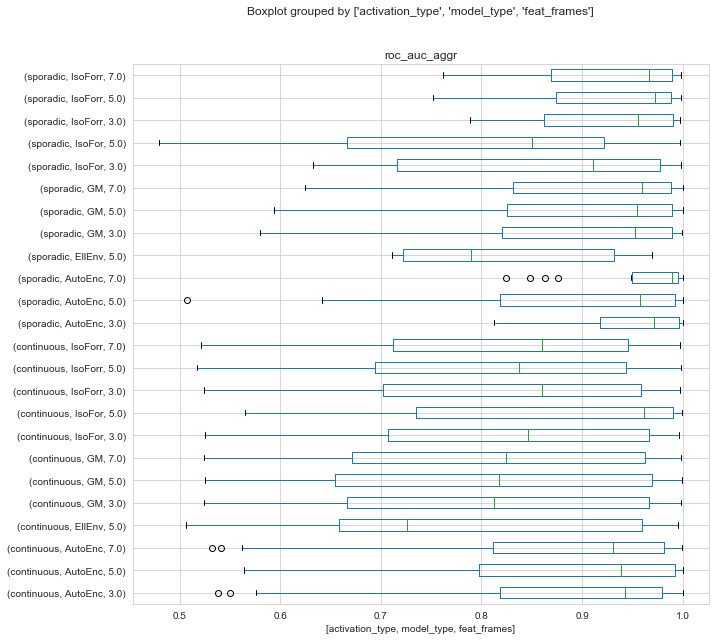

In [25]:
plt.figure(figsize=(10,10))
df[(df.feat_frames != np.nan)].boxplot(column='roc_auc_aggr', by=[
    'activation_type', 'model_type', 'feat_frames'], figsize=(10,10), vert=False)
#sns.boxplot(data=df[~df.feat_frames.isna()], x='roc_auc_aggr', y='feat_frames')

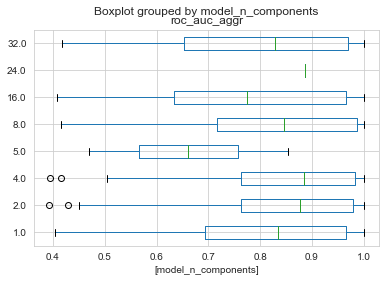

In [26]:
df.boxplot(column='roc_auc_aggr', by=['model_n_components'], vert=False)

<Figure size 1080x1080 with 0 Axes>

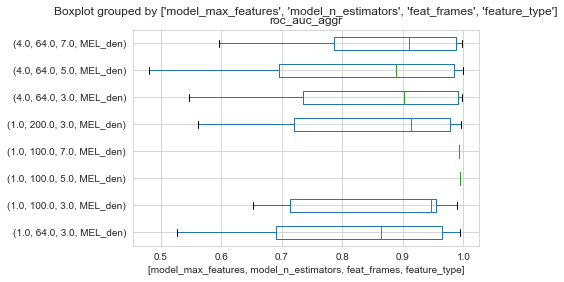

In [27]:
plt.figure(figsize=(15,15));
df[df.feature_type=='MEL_den'].boxplot(column='roc_auc_aggr', by=['model_max_features', 'model_n_estimators', 'feat_frames', 'feature_type'], vert=False)

<Figure size 1080x1080 with 0 Axes>

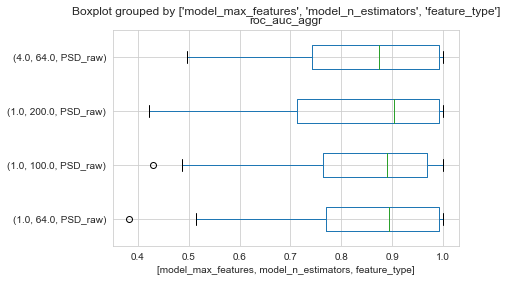

In [28]:
plt.figure(figsize=(15,15));
df[df.feature_type=='PSD_raw'].boxplot(column='roc_auc_aggr', by=['model_max_features', 'model_n_estimators', 'feature_type'], vert=False)

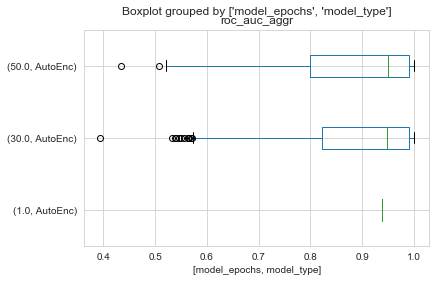

In [29]:
df.boxplot(column='roc_auc_aggr', by=['model_epochs', 'model_type'], vert=False)

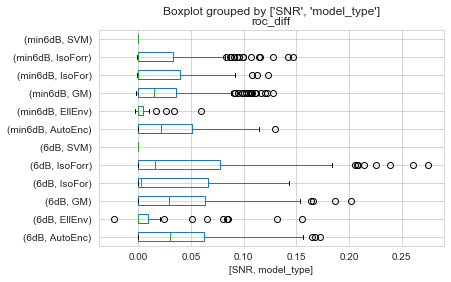

In [30]:
df.boxplot(column='roc_diff', by=['SNR', 'model_type'], vert=False)